In [140]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

import sklearn

import requests
import json

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings(action='ignore')

In [59]:
start_i = 1
end_i = 10000
code = "732Y001"
period = "M"
start_date = '201501'
end_date = '202401'

req = requests.get(f'https://ecos.bok.or.kr/api/StatisticSearch/10E0Q11L9OP2VEVT6XMK/xml/kr/{start_i}/{end_i}/{code}/{period}/{start_date}/{end_date}')
soup = BeautifulSoup(req.text, 'lxml')
soup

<?xml version="1.0" encoding="UTF-8"?><html><body><statisticsearch>
<list_total_count number="true">535</list_total_count>
<row>
<stat_code>732Y001</stat_code>
<stat_name>3.5. 외환보유액</stat_name>
<item_code1>02</item_code1>
<item_name1>특별인출권</item_name1>
<item_code2></item_code2>
<item_name2></item_name2>
<item_code3></item_code3>
<item_name3></item_name3>
<item_code4></item_code4>
<item_name4></item_name4>
<unit_name>천달러 </unit_name>
<time>201501</time>
<data_value>3189213</data_value>
</row>
<row>
<stat_code>732Y001</stat_code>
<stat_name>3.5. 외환보유액</stat_name>
<item_code1>01</item_code1>
<item_name1>금</item_name1>
<item_code2></item_code2>
<item_name2></item_name2>
<item_code3></item_code3>
<item_name3></item_name3>
<item_code4></item_code4>
<item_name4></item_name4>
<unit_name>천달러 </unit_name>
<time>201501</time>
<data_value>4794747</data_value>
</row>
<row>
<stat_code>732Y001</stat_code>
<stat_name>3.5. 외환보유액</stat_name>
<item_code1>03</item_code1>
<item_name1>IMF포지션</item_name1>
<i

In [81]:
item_name1_li = [x.get_text() for x in soup.select('item_name1')]
time_li = [x.get_text() for x in soup.select('time')]
data_value_li = [x.get_text() for x in soup.select('data_value')]

df = pd.DataFrame(data={
    'item':item_name1_li,
    'date':time_li,
    'value':data_value_li
})


df = df.pivot_table(index='date',columns='item', values='value')
df = df.astype('int64')
df = df.rename(columns={'IMF포지션':'imf','금':'gold','외환':'securities_and_deposits', '특별인출권':'sdr','합계':'sum'})
df


item,imf,gold,securities_and_deposits,sdr,sum
date,,,,,
201501,1864779,4794747,352337447,3189213,362186186
201502,1871794,4794747,352502108,3201425,362370074
201503,1490819,4794747,353332770,3131927,362750264
201504,1463596,4794747,360481327,3162416,369902086
201505,1455843,4794747,362109803,3145219,371505613
...,...,...,...,...,...
202307,4712155,4794759,397490841,14806052,421803807
202308,4593652,4794759,393866255,15046428,418301093
202309,4535976,4794759,389988672,14798410,414117817


- sum은 단순 합계이므로 제외
- gold는 변화가 미미하므로 제외

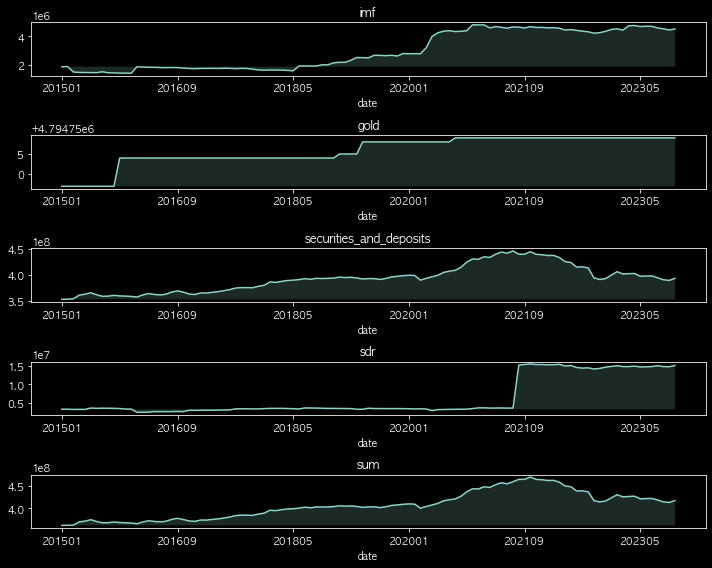

In [141]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,8))

for i in range(len(df.columns)):
    df.iloc[:,i].plot(ax=axes[i])
    axes[i].set_title(df.columns[i])
    axes[i].fill_between(y1=df.iloc[0,i], y2=df.iloc[:,i],x=list(df.index), alpha=0.2)
    
plt.tight_layout()
plt.show()

In [83]:
from statsmodels.tsa.stattools import grangercausalitytests

In [142]:
df

item,imf,gold,securities_and_deposits,sdr,sum
date,,,,,
201501,1864779,4794747,352337447,3189213,362186186
201502,1871794,4794747,352502108,3201425,362370074
201503,1490819,4794747,353332770,3131927,362750264
201504,1463596,4794747,360481327,3162416,369902086
201505,1455843,4794747,362109803,3145219,371505613
...,...,...,...,...,...
202307,4712155,4794759,397490841,14806052,421803807
202308,4593652,4794759,393866255,15046428,418301093
202309,4535976,4794759,389988672,14798410,414117817


In [143]:
df_cols = df.columns[[0,2,3]]
df_pairs = pd.DataFrame(data=np.zeros((len(df_cols), len(df_cols))),
                        columns = ['X_'+x for x in df_cols],
                        index = ['Y_'+y for y in df_cols]
                        )
df_pairs

,X_imf,X_securities_and_deposits,X_sdr
Y_imf,0.0,0.0,0.0
Y_securities_and_deposits,0.0,0.0,0.0
Y_sdr,0.0,0.0,0.0


In [144]:
maxlag = 4
for col_i, col in enumerate(df_cols):
    for idx_i, idx in enumerate(df_cols):
        outs = grangercausalitytests(df[[col,idx]], maxlag=maxlag)
        pval_min = np.min([round(outs[x][0]['ssr_chi2test'][1],2) for x in range(1, maxlag+1)])
        df_pairs.iloc[idx_i, col_i] = pval_min


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=104, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=9932.9773, p=0.0000  , df_denom=104, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=102, df_num=2
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=5179.9066, p=0.0000  , df_denom=102, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=100, df_num=3
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=3688.4852, p=0.0000  , df_denom=100, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0000  , p=1.000

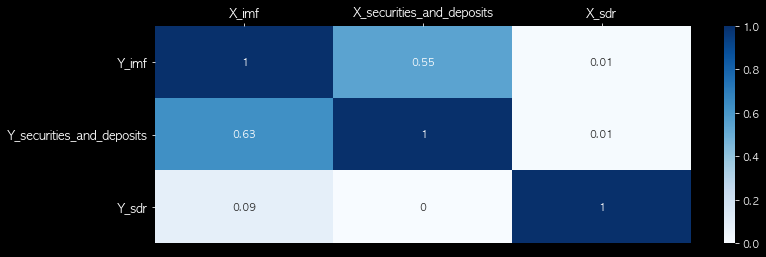

In [145]:
import seaborn as sns

plt.figure(figsize=(12,4))
ax = sns.heatmap(df_pairs, annot=True, cmap='Blues')
ax.xaxis.tick_top()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

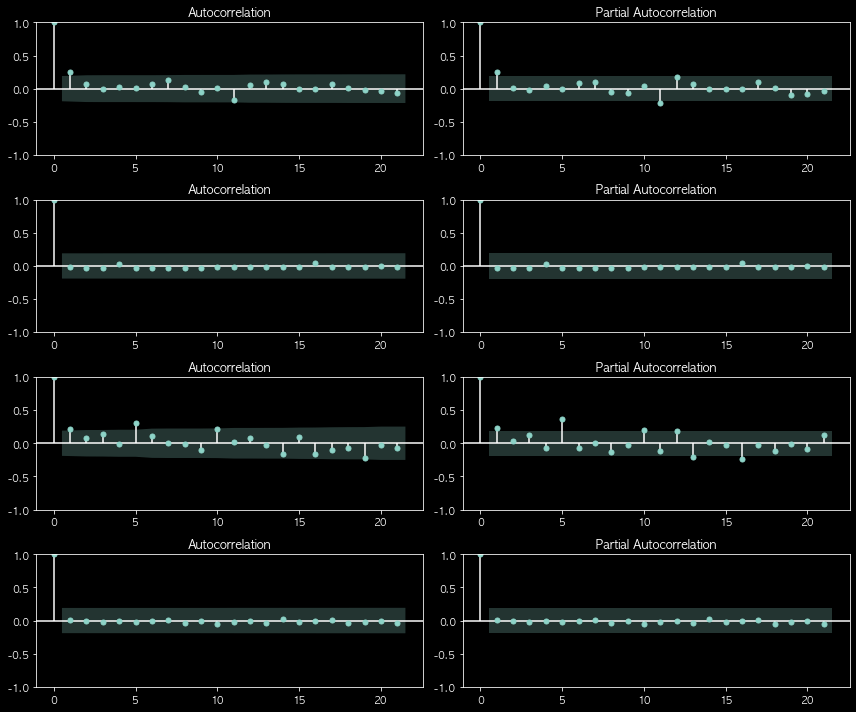

In [90]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(12,10))

plot_acf(df['imf'].diff().dropna(), ax=axes[0,0])
plot_acf(df['gold'].diff().dropna(), ax=axes[1,0])
plot_acf(df['securities_and_deposits'].diff().dropna(), ax=axes[2,0])
plot_acf(df['sdr'].diff().dropna(), ax=axes[3,0])

plot_pacf(df['imf'].diff().dropna(), ax=axes[0,1])
plot_pacf(df['gold'].diff().dropna(), ax=axes[1,1])
plot_pacf(df['securities_and_deposits'].diff().dropna(), ax=axes[2,1])
plot_pacf(df['sdr'].diff().dropna(), ax=axes[3,1])

plt.tight_layout()
plt.show()

In [91]:
from statsmodels.tsa.stattools import adfuller

def adf_test(data, name):
    result = adfuller(data.values)
    print(name)
    print(f'>> statistics: {result[0]:.3f}')
    print(f'>> p_value: {result[1]:.3f}')
    print(f'>> critical values(5%):{result[4]["5%"]:.3f}')
    if result[1] < 0.05:
        print('pass!! :)')
    else:
        print('fail :(')
    print('--------------------------')

adf_test(df['imf'].diff().dropna(), name='imf (d:1)')
adf_test(df['gold'].diff().dropna(), name='gold (d:1)')
adf_test(df['securities_and_deposits'].diff().dropna(), name='securities_and_deposits (d:1)')
adf_test(df['sdr'].diff().dropna(), name='sdr (d:1)')

imf (d:1)
>> statistics: -7.842
>> p_value: 0.000
>> critical values(5%):-2.889
pass!! :)
--------------------------
gold (d:1)
>> statistics: -4.980
>> p_value: 0.000
>> critical values(5%):-2.890
pass!! :)
--------------------------
securities_and_deposits (d:1)
>> statistics: -2.853
>> p_value: 0.051
>> critical values(5%):-2.891
fail :(
--------------------------
sdr (d:1)
>> statistics: -10.102
>> p_value: 0.000
>> critical values(5%):-2.889
pass!! :)
--------------------------


In [114]:
df

item,imf,gold,securities_and_deposits,sdr,sum
date,,,,,
201501,1864779,4794747,352337447,3189213,362186186
201502,1871794,4794747,352502108,3201425,362370074
201503,1490819,4794747,353332770,3131927,362750264
201504,1463596,4794747,360481327,3162416,369902086
201505,1455843,4794747,362109803,3145219,371505613
...,...,...,...,...,...
202307,4712155,4794759,397490841,14806052,421803807
202308,4593652,4794759,393866255,15046428,418301093
202309,4535976,4794759,389988672,14798410,414117817


In [113]:
df.iloc[:,:-1].diff()

item,imf,gold,securities_and_deposits,sdr
date,,,,
201501,NaN,NaN,NaN,NaN
201502,7015.0,0.0,164661.0,12212.0
201503,-380975.0,0.0,830662.0,-69498.0
201504,-27223.0,0.0,7148557.0,30489.0
201505,-7753.0,0.0,1628476.0,-17197.0
...,...,...,...,...
202307,-4178.0,0.0,288433.0,65629.0
202308,-118503.0,0.0,-3624586.0,240376.0
202309,-57676.0,0.0,-3877583.0,-248018.0


In [119]:
df_diff_norm

item,imf,gold,securities_and_deposits,sdr,sum
date,,,,,
201502,0.000000,NaN,0.000000,0.000000,0.000000
201503,-55.308624,NaN,4.044680,-6.690960,1.067508
201504,-4.880684,NaN,42.413783,1.496643,37.892271
201505,-2.105203,NaN,8.889871,-2.408205,7.720129
201506,-1.269138,NaN,16.410061,30.016705,16.639242
...,...,...,...,...,...
202307,-1.595581,NaN,0.751678,4.374140,0.902702
202308,-17.892801,NaN,-23.012413,18.683590,-20.048084
202309,-9.221810,NaN,-24.548885,-21.309368,-23.749043


In [124]:
df.iloc[:,[0,2,3]]

item,imf,securities_and_deposits,sdr
date,,,
201501,1864779,352337447,3189213
201502,1871794,352502108,3201425
201503,1490819,353332770,3131927
201504,1463596,360481327,3162416
201505,1455843,362109803,3145219
...,...,...,...
202307,4712155,397490841,14806052
202308,4593652,393866255,15046428
202309,4535976,389988672,14798410


In [126]:
df_diff_norm

item,imf,securities_and_deposits,sdr
date,,,
201502,0.000000,0.000000,0.000000
201503,-55.308624,4.044680,-6.690960
201504,-4.880684,42.413783,1.496643
201505,-2.105203,8.889871,-2.408205
201506,-1.269138,16.410061,30.016705
...,...,...,...
202307,-1.595581,0.751678,4.374140
202308,-17.892801,-23.012413,18.683590
202309,-9.221810,-24.548885,-21.309368


In [136]:
df_diff_norm = df.iloc[:,[0,2,3]].diff().dropna()
#df_diff_norm = (df_diff_norm / df_diff_norm.iloc[0]) - 1
df_diff_norm = (df_diff_norm - df_diff_norm.min()) / df_diff_norm.max()
df_diff_norm

item,imf,securities_and_deposits,sdr
date,,,
201502,0.488923,1.982250,0.076417
201503,0.000000,2.050241,0.069427
201504,0.445779,2.695226,0.077981
201505,0.470314,2.131689,0.073901
201506,0.477704,2.258104,0.107774
...,...,...,...
202307,0.474819,1.994886,0.080987
202308,0.330753,1.595412,0.095935
202309,0.407403,1.569584,0.054156


In [139]:
from statsmodels.tsa.api import VAR

df_diff_norm = df.iloc[:,[0,2,3]].diff().dropna()
df_diff_norm = (df_diff_norm / df_diff_norm.iloc[0]) - 1
df_diff_norm = (df_diff_norm - df_diff_norm.min()) / df_diff_norm.max()

var = VAR(df_diff_norm)
var.select_order(maxlags=10).summary()

/Users/swsong/opt/anaconda3/envs/dataScience/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-9.968*,-9.888*,4.688e-05*,-9.936*
1,-9.939,-9.618,4.828e-05,-9.809
2,-9.811,-9.250,5.491e-05,-9.584
3,-9.702,-8.901,6.129e-05,-9.378
4,-9.533,-8.491,7.282e-05,-9.111
5,-9.569,-8.287,7.050e-05,-9.051
6,-9.454,-7.931,7.963e-05,-8.839
7,-9.369,-7.606,8.745e-05,-8.657
8,-9.347,-7.343,9.052e-05,-8.537
9,-9.253,-7.009,0.0001010,-8.346
